<a href="https://colab.research.google.com/github/enitin-agarwal/azureforaws/blob/master/ML_DL_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import torch
import torch.nn as nn
import torch.optim as optim
!pip install torch_geometric
!pip install torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
from google.cloud import bigquery
from google.colab import auth


# Authenticate and Initialize BigQuery Client
auth.authenticate_user()
print('Authenticated')
client = bigquery.Client(project='ultimate-balm-449016-q6')

# Load Datasets from MIMIC-III Demo
def load_data(query):
    return client.query(query).to_dataframe()

admissions = load_data("SELECT * FROM `physionet-data.mimiciii_demo.admissions` LIMIT 10000")
patients = load_data("SELECT * FROM `physionet-data.mimiciii_demo.patients`")
events = load_data("SELECT * FROM `physionet-data.mimiciii_demo.chartevents`")
items = load_data("SELECT * FROM `physionet-data.mimiciii_demo.d_items`")
notes = load_data("SELECT * FROM `physionet-data.mimiciii_notes.noteevents` LIMIT 10000")
diagnoses = load_data("SELECT * FROM `physionet-data.mimiciii_demo.diagnoses_icd`")

# --- Data Preprocessing ---
print("Preprocessing Data...")

# Merge datasets
data = pd.merge(admissions, patients, on='SUBJECT_ID', how='inner')
data = pd.merge(data, events, on=['SUBJECT_ID', 'HADM_ID'], how='left')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 11.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1E

Authenticated
Preprocessing Data...


In [2]:
# Enhanced Missing Value Imputation
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

for col in num_cols:
   if data[col].dtype == 'Int64':
           data[col] = data[col].fillna(int(data[col].mean()))
   else:
           data[col] = data[col].fillna(data[col].mean())
for col in cat_cols:
    if data[col].mode().empty:
        # If empty, fill with a placeholder or drop the column
        data[col].fillna('missing', inplace=True)  # Replace 'missing' with a suitable placeholder
    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

# NLP on Discharge Notes
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
discharge_notes = notes[notes['CATEGORY'] == 'Discharge summary'][['SUBJECT_ID', 'TEXT']]
discharge_notes['sentiment'] = discharge_notes['TEXT'].apply(lambda x: sia.polarity_scores(str(x))['compound'])



<ipython-input-2-f9a195315c2c>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
# --- Feature Engineering ---
print("Performing Feature Engineering...")

# Calculate age
data['age'] = (pd.to_datetime(data['DISCHTIME']) - pd.to_datetime(data['DOB'])).dt.days // 365

# Extract vital signs with ITEMIDs (MIMIC-III specific)
heart_rate_ids = [211, 220045]
temp_ids = [223761, 676]
resp_rate_ids = [618, 220210]
o2_sat_ids = [646, 220277]

vital_data = {
    'avg_heart_rate': (heart_rate_ids, 'mean'),
    'max_temperature': (temp_ids, 'max'),
    'avg_resp_rate': (resp_rate_ids, 'mean'),
    'avg_o2_sat': (o2_sat_ids, 'mean')
}

for feature, (item_ids, agg_func) in vital_data.items():
    temp = events[events['ITEMID'].isin(item_ids)].groupby('HADM_ID')['VALUENUM'].agg([agg_func]).reset_index()
    temp.columns = ['HADM_ID', feature]
    # Convert 'HADM_ID' to numeric, handling errors
    temp['HADM_ID'] = pd.to_numeric(temp['HADM_ID'], errors='coerce')
    #If 'HADM_ID' can't be converted to a number, it becomes NaN
    temp = temp.dropna(subset=['HADM_ID']) #Remove rows with NaN 'HADM_ID'
    temp['HADM_ID'] = temp['HADM_ID'].astype(int) #Convert to int after removing NaNs
    data['HADM_ID'] = pd.to_numeric(data['HADM_ID'], errors='coerce')
    data = data.dropna(subset=['HADM_ID'])
    data['HADM_ID'] = data['HADM_ID'].astype(int)
    data = data.merge(temp, on='HADM_ID', how='left')

# Merge sentiment and diagnoses
data = data.merge(discharge_notes[['SUBJECT_ID', 'sentiment']], on='SUBJECT_ID', how='left')
patient_diagnoses = diagnoses.groupby('SUBJECT_ID')['ICD9_CODE'].apply(list).reset_index()

# Define sepsis target (ICD-9 codes: 99591, 99592)
sepsis_codes = ['99591', '99592']
patient_diagnoses['sepsis'] = patient_diagnoses['ICD9_CODE'].apply(lambda x: 1 if any(code in sepsis_codes for code in x) else 0)
data = data.merge(patient_diagnoses[['SUBJECT_ID', 'sepsis']], on='SUBJECT_ID', how='left')
data['sepsis'].fillna(0, inplace=True)

# Static features
static_features = ['age', 'GENDER', 'ETHNICITY', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'DIAGNOSIS']
X = data[static_features + ['avg_heart_rate', 'max_temperature', 'avg_resp_rate', 'avg_o2_sat', 'sentiment']]
y = data['sepsis']

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)
X.fillna(0, inplace=True)  # Fill any remaining NaNs after merging

# Train-test split with indices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_indices = X_train.index
test_indices = X_test.index

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Total features: {X_train.shape[1]}")

# --- Model Training and Evaluation ---
def evaluate_model(y_true, y_pred, y_prob=None, name="Model"):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_prob) if y_prob is not None else None
    }
    print(f"{name} Evaluation:")
    for metric, value in metrics.items():
        if value is not None:
            print(f"{metric}: {value:.4f}")
    print()
    return metrics

# 1. Traditional ML Models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    results[name] = evaluate_model(y_test, y_pred, y_prob, name)

# 2. Siamese Network with Contrastive Learning
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        return loss

class SiameseNetwork(nn.Module):
    def __init__(self, input_dim):
        super(SiameseNetwork, self).__init__()
        self.shared_fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )

# Generate pairs
def generate_pairs(X, y, num_pairs=5000):
    pairs, labels = [], []
    X_np, y_np = X.values, y.values
    for _ in range(num_pairs):
        idx1, idx2 = np.random.randint(0, len(X), 2)
        # Convert to numeric types before creating tensors
        pairs.append((X_np[idx1].astype(np.float64), X_np[idx2].astype(np.float64)))
        #pairs.append((X_np[idx1], X_np[idx2]))
        labels.append(1 if y_np[idx1] == y_np[idx2] else 0)
    return pairs, labels

pairs, pair_labels = generate_pairs(X_train, y_train)
siamese_model = SiameseNetwork(X_train.shape[1])
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)

# Train Siamese Network
for epoch in range(20):
    siamese_model.train()
    total_loss = 0
    for (x1, x2), label in zip(pairs, pair_labels):
        x1 = torch.tensor(x1).float().unsqueeze(0)
        x2 = torch.tensor(x2).float().unsqueeze(0)
        label = torch.tensor(label).float().unsqueeze(0)
        optimizer.zero_grad()
        out1, out2 = siamese_model.shared_fc(x1), siamese_model.shared_fc(x2)
        loss = criterion(out1, out2, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Siamese Epoch [{epoch+1}/20], Loss: {total_loss / len(pairs):.4f}")

# Use embeddings for classification
with torch.no_grad():
    siamese_model.eval()
    train_embeddings = siamese_model.shared_fc(torch.tensor(X_train_scaled).float()).numpy()
    test_embeddings = siamese_model.shared_fc(torch.tensor(X_test_scaled).float()).numpy()

clf = LogisticRegression(random_state=42)
clf.fit(train_embeddings, y_train)
y_pred_siamese = clf.predict(test_embeddings)
y_prob_siamese = clf.predict_proba(test_embeddings)[:, 1]
results['Siamese'] = evaluate_model(y_test, y_pred_siamese, y_prob_siamese, "Siamese Network")



Performing Feature Engineering...


<ipython-input-3-6864fcb7fb9b>:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['sepsis'].fillna(0, inplace=True)


Total features: 119
RandomForest Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:51:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Siamese Epoch [1/20], Loss: 1.9908
Siamese Epoch [2/20], Loss: 0.3595
Siamese Epoch [3/20], Loss: 0.3183
Siamese Epoch [4/20], Loss: 0.3114
Siamese Epoch [5/20], Loss: 0.3397
Siamese Epoch [6/20], Loss: 0.3545
Siamese Epoch [7/20], Loss: 0.3612
Siamese Epoch [8/20], Loss: 0.5407
Siamese Epoch [9/20], Loss: 0.5448
Siamese Epoch [10/20], Loss: 0.5448
Siamese Epoch [11/20], Loss: 0.5448
Siamese Epoch [12/20], Loss: 0.5448
Siamese Epoch [13/20], Loss: 0.5448
Siamese Epoch [14/20], Loss: 0.5448
Siamese Epoch [15/20], Loss: 0.5448
Siamese Epoch [16/20], Loss: 0.5448
Siamese Epoch [17/20], Loss: 0.5448
Siamese Epoch [18/20], Loss: 0.5448
Siamese Epoch [19/20], Loss: 0.5448
Siamese Epoch [20/20], Loss: 0.5448
Siamese Network Evaluation:
Accuracy: 0.8080
Precision: 0.8635
Recall: 0.5419
F1 Score: 0.6659
ROC AUC: 0.8192



Building Knowledge Graph...
GCN Epoch [10/50], Loss: 0.0000
GCN Epoch [20/50], Loss: 0.0000
GCN Epoch [30/50], Loss: 0.0000
GCN Epoch [40/50], Loss: 0.0000
GCN Epoch [50/50], Loss: 0.0000
GCN Evaluation:
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: nan



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: U

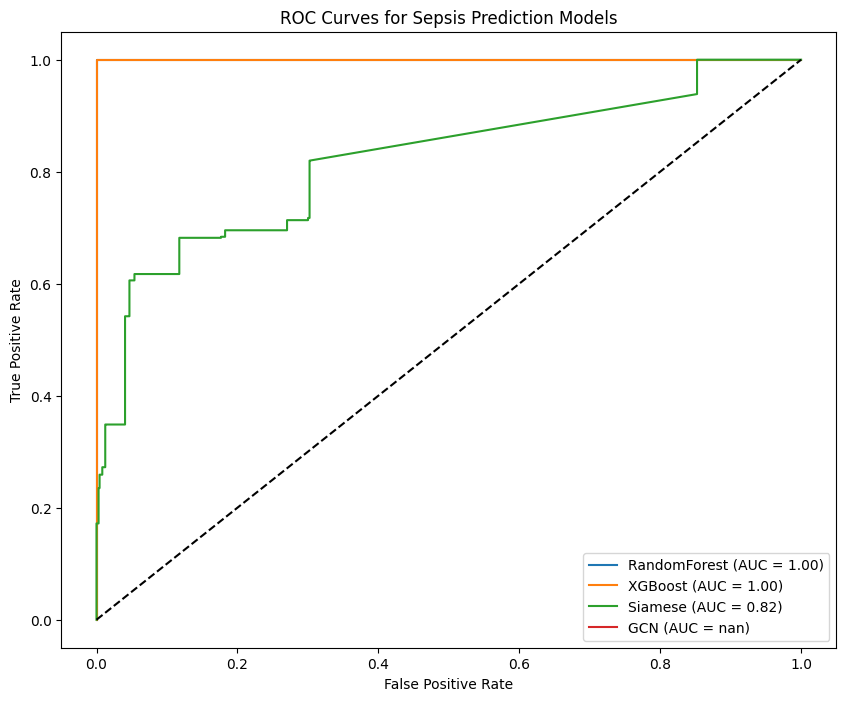

Analysis completed!


In [5]:
# 3. Graph Convolutional Network (GCN)
print("Building Knowledge Graph...")
G = nx.Graph()
for idx, row in data.iterrows():
    G.add_node(row['SUBJECT_ID'], age=row['age'], sentiment=row['sentiment'])

# Edges based on shared diagnoses
diagnosis_to_patients = {}
for _, row in patient_diagnoses.iterrows():
    for diag in row['ICD9_CODE']:
        diagnosis_to_patients.setdefault(diag, []).append(row['SUBJECT_ID'])
for patients in diagnosis_to_patients.values():
    for i in range(len(patients)):
        for j in range(i + 1, len(patients)):
            G.add_edge(patients[i], patients[j])

# Convert to PyTorch Geometric
node_ids = list(G.nodes)
#node_to_index = {node: idx for idx, node in enumerate(node_ids)}
#edge_index = torch.tensor(list(G.edges)).t().contiguous()
# Create a mapping from node ID to a continuous index range
node_to_index = {node: idx for idx, node in enumerate(node_ids)}
# Map the original node IDs in edge_index to the continuous index range
edge_index = torch.tensor([[node_to_index[u], node_to_index[v]] for u, v in G.edges]).t().contiguous()

node_features = torch.tensor([[data[data['SUBJECT_ID'] == nid]['age'].iloc[0],
                              data[data['SUBJECT_ID'] == nid]['sentiment'].iloc[0] if pd.notna(data[data['SUBJECT_ID'] == nid]['sentiment'].iloc[0]) else 0]
                             for nid in node_ids], dtype=torch.float)

graph_data = Data(x=node_features, edge_index=edge_index)
#y_all = data.set_index('SUBJECT_ID').loc[node_ids]['sepsis'].values #Original Line
y_all = torch.tensor(data.set_index('SUBJECT_ID').loc[node_ids]['sepsis'].values, dtype=torch.float) #Updated Line: Convert to tensor before indexing

#train_mask = torch.tensor([nid in data.loc[train_indices, 'SUBJECT_ID'].values for nid in node_ids], dtype=torch.bool) #Original Line
#test_mask = torch.tensor([nid in data.loc[test_indices, 'SUBJECT_ID'].values for nid in node_ids], dtype=torch.bool) #Original Line
train_mask = torch.tensor([node_to_index[nid] for nid in data.loc[train_indices, 'SUBJECT_ID'].values if nid in node_to_index], dtype=torch.long)  # Updated Line
test_mask = torch.tensor([node_to_index[nid] for nid in data.loc[test_indices, 'SUBJECT_ID'].values if nid in node_to_index], dtype=torch.long)  # Updated Line

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

gcn_model = GCN(2, 16, 1)
optimizer = optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# Train GCN
for epoch in range(50):
    gcn_model.train()
    out = gcn_model(graph_data).squeeze()
    #loss = criterion(out[train_mask], torch.tensor(y_all[train_mask], dtype=torch.float)) #Original Line
    loss = criterion(out[train_mask], y_all[train_mask])  # Updated Line    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"GCN Epoch [{epoch+1}/50], Loss: {loss.item():.4f}")

# Evaluate GCN
with torch.no_grad():
    gcn_model.eval()
    out = gcn_model(graph_data).squeeze()
    y_prob_gcn = torch.sigmoid(out[test_mask]).numpy()
    y_pred_gcn = (y_prob_gcn > 0.5).astype(int)
    #results['GCN'] = evaluate_model(y_all[test_mask], y_pred_gcn, y_prob_gcn, "GCN") #Original Line
    results['GCN'] = evaluate_model(y_all[test_mask].cpu().numpy(), y_pred_gcn, y_prob_gcn, "GCN")  # Updated Line: Move to CPU and convert to NumPy

# --- Visualization ---
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")

fpr, tpr, _ = roc_curve(y_test, y_prob_siamese)
plt.plot(fpr, tpr, label=f"Siamese (AUC = {roc_auc_score(y_test, y_prob_siamese):.2f})")

fpr, tpr, _ = roc_curve(y_all[test_mask], y_prob_gcn)
plt.plot(fpr, tpr, label=f"GCN (AUC = {roc_auc_score(y_all[test_mask], y_prob_gcn):.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Sepsis Prediction Models')
plt.legend()
plt.show()

print("Analysis completed!")